In [1]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import glob
import re
import os
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import albumentations as A

In [2]:
from torchvision import transforms
import torchvision.datasets as datasets

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
path2img = "/media/brats/DRIVE1/akansh/lung-seg/data/images/"
path2mask = "/media/brats/DRIVE1/akansh/lung-seg/data/masks/"

In [12]:
class LungDataset(Dataset):
    
    def __init__(self, img_dir, mask_dir, transform = None):
        
        self.img_dir = [os.path.join(img_dir,i) for i in os.listdir(img_dir) if i.endswith('png')]
        self.img_dir.sort()
        self.mask_dir = None
        if mask_dir is not None:
            self.mask_dir = [os.path.join(mask_dir,i) for i in os.listdir(mask_dir) if i.endswith('png')]
            self.mask_dir.sort()
        self.transforms = transform
        self.norm_transform = A.Normalize()

    def __len__(self):
        return len(self.img_dir)
    
    def __getitem__(self,idx):
        img = cv2.imread(self.img_dir[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ###Normalize
#         img = self.norm_transform(img)

        if self.mask_dir is not None:
            mask = cv2.imread(self.mask_dir[idx])[:, :, 0]
            mask = np.clip(mask, 0, 1).astype("float32")
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
#             im = self.post_transforms(img)
            return  torch.tensor(img), torch.FloatTensor(mask)
        
        else:
            augmented = self.transforms(image=img)
            img = augmented['image']
            im = self.post_transforms(img)
            return torch.tensor(img)  

In [6]:
# def get_mean_std(loader):
#     channels_sum, channels_squared_sum, num_batches = 0,0,0
    
#     for data,_ in tqdm(loader):
#         channels_sum += torch.mean(data, dim = [0,2,3])
#         channels_squared_sum += torch.mean(data**2, dim = [0,2,3])
#         num_batches += 1
        
#     mean = channels_sum/num_batches
#     std = (channels_squared_sum/num_batches - mean**2)**0.5
    
#     return mean, std

# class LungDataset(Dataset):
    
#     def __init__(self, img_dir, mask_dir, transforms = None):
        
#         self.img_dir = [os.path.join(img_dir,i) for i in os.listdir(img_dir) if i.endswith('png')]
#         self.img_dir.sort()
#         self.mask_dir = None
#         if mask_dir is not None:
#             self.mask_dir = [os.path.join(mask_dir,i) for i in os.listdir(mask_dir) if i.endswith('png')]
#             self.mask_dir.sort()
#         self.transforms = transforms        
#     def __len__(self):
#         return len(self.img_dir)
    
#     def __getitem__(self,idx):
#         img = cv2.imread(self.img_dir[idx], cv2.IMREAD_GRAYSCALE)
#         if self.mask_dir is not None:
#             mask = cv2.imread(self.mask_dir[idx], cv2.IMREAD_GRAYSCALE)
#             mask = np.clip(mask, 0, 1).astype("float32")
#             augmented = self.transforms(image=img, mask=mask)
#             img = augmented['image']
#             mask = augmented['mask']
#             return torch.tensor(img), torch.FloatTensor(mask)
        
#         else:
# #             augmented = self.transforms(image=img)
# #             img = augmented['image']
#             return self.transforms(img), 0  
# trainset = LungDataset(img_dir = path2img, mask_dir = None, transforms = transforms.ToTensor())


# train_loader = DataLoader(dataset = trainset, batch_size = 64, shuffle = True)

# mean, std = get_mean_std(train_loader)
# print(f"Mean: {mean}, STD: {std}")

In [64]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Rotate((-30,30), p = 0.5),
#     A.ElasticTransform(p=0.5, alpha=1, sigma=50, alpha_affine=10),
#     A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.3),
#     A.GridDistortion(p=0.5),
#     A.OpticalDistortion(distort_limit=0.8, shift_limit=0.6, p=1),
#     A.RandomSizedCrop(min_max_height=(150, 200), height=224, width=224, p=0.5),
#     A.CLAHE(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p = 0.5),
    A.GaussianBlur(p = 0.5),
    A.GaussNoise(p = 0.5), 
    
        ])


test_transforms = A.Compose([
    A.Rotate(0, p = 1)
        ])

In [65]:
lung_data_1 = LungDataset(img_dir = path2img, mask_dir = path2mask, transform = train_transforms)
lung_data_2 = LungDataset(img_dir = path2img, mask_dir = path2mask, transform = test_transforms)

In [66]:
for x, y in lung_data_1:
    print(x.shape)
    print(y)
    break

torch.Size([224, 224, 3])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


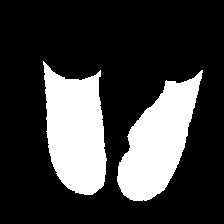

In [67]:
Image.fromarray(y.numpy().astype('bool'))

In [68]:
len(lung_data_1)

138

### Spliting the dataset

In [36]:
from sklearn.model_selection import ShuffleSplit

In [37]:
sss = ShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

In [38]:
indices=range(len(lung_data_1))
for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

124
----------
14


In [39]:
from torch.utils.data import Subset
train_ds=Subset(lung_data_1,train_index)
print(len(train_ds))
print("-"*10)

val_ds=Subset(lung_data_2,val_index)
print(len(val_ds))

124
----------
14


In [40]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

In [41]:
for img_b, mask_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([8, 224, 224, 3]) torch.uint8
torch.Size([8, 224, 224]) torch.float32


### Model

In [69]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_classes=1):
        super().__init__()
        
        self.base_model = torchvision.models.resnet50(pretrained=False)
        
        self.base_layers = list(self.base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])        
        self.layer1_1x1 = convrelu(256, 256, 1, 0)       
        self.layer2 = self.base_layers[5]         
        self.layer2_1x1 = convrelu(512, 512, 1, 0)  
        self.layer3 = self.base_layers[6]         
        self.layer3_1x1 = convrelu(1024, 1024, 1, 0)  
        self.layer4 = self.base_layers[7] 
        self.layer4_1x1 = convrelu(2048, 2048, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(1024 + 2048, 1024, 3, 1)
        self.conv_up2 = convrelu(512 + 1024, 512, 3, 1)
        self.conv_up1 = convrelu(256 + 512, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 64, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_classes, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2) 
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)
        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)
        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)
        
        out = torch.sigmoid(self.conv_last(x))  

        return out

In [70]:
model = ResNetUNet().to('cuda');

In [71]:
def jaccard_coef_metric(inputs, target, eps=1e-7):
    intersection = (target * inputs).sum()
    union = (target.sum() + inputs.sum()) - intersection + eps

    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return (intersection + eps) / union

def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

## Loss

def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

In [72]:
def train_one_epoch(model, optimizer, lr_scheduler, metric,
                    dataloader, epoch, criterion=bce_dice_loss):
    
    print("Start Train ...")
    model.train()

    losses = []
    accur = []

    for data, target in tqdm(dataloader):

        data = data.permute(0,3,1,2).to(DEVICE).float()
        targets = target.unsqueeze(1).to(DEVICE)

        outputs = model(data)

        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

        train_dice = metric(out_cut, targets.data.cpu().numpy())

        loss = criterion(outputs, targets)

        losses.append(loss.item())
        accur.append(train_dice)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if lr_scheduler is not None:
        lr_scheduler.step()

    lr = lr_scheduler.get_last_lr()[0]
    print("Epoch [%d]" % (epoch),
          "Mean loss on train:", np.array(losses).mean(), 
          "Mean DICE on train:", np.array(accur).mean(), 
          "Learning Rate:", lr)

    
    return np.array(losses).mean(), np.array(accur).mean(), lr


def val_epoch(model, metric, dataloader, epoch, threshold=0.5):
    
    print("Start Validation ...")
    model.eval()
    
    val_acc = []

    with torch.no_grad():
        for data, targets in tqdm(dataloader):

            data = data.permute(0,3,1,2).to(DEVICE).float()
            targets = targets.unsqueeze(1).to(DEVICE)

            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            val_dice = metric(out_cut, targets.data.cpu().numpy())
            val_acc.append(val_dice)

        print("Epoch:  " + str(epoch) + "  Threshold:  " + str(threshold)\
              + " Mean Validation DICE Score:", np.array(val_acc).mean())
        
        return  np.array(val_acc).mean()

In [73]:
for param in model.parameters():
    param.requires_grad = True
    
params = [p for p in model.parameters() if p.requires_grad]

stage_epoch =  [20, 15, 10] #[12, 8, 5]
stage_optimizer = [
    torch.optim.Adamax(params, lr=0.0002),
    torch.optim.SGD(params, lr=0.00009, momentum=0.9),
    torch.optim.Adam(params, lr=0.00005),
]

stage_scheduler = [
    torch.optim.lr_scheduler.CosineAnnealingLR(stage_optimizer[0], 4, 1e-6),
    torch.optim.lr_scheduler.CyclicLR(stage_optimizer[1], base_lr=1e-5, max_lr=2e-4),
    torch.optim.lr_scheduler.CosineAnnealingLR(stage_optimizer[2], 4, 1e-6),
]

In [74]:
DEVICE = 'cuda'
weights_dir = "weights"
if os.path.exists(weights_dir) == False:
    os.mkdir(weights_dir)


loss_history = []
train_dice_history = []
val_dice_history = []
lr_history = []

for k, (num_epochs, optimizer, lr_scheduler) in enumerate(zip(stage_epoch, stage_optimizer, stage_scheduler)):
    for epoch in range(num_epochs):
        
        
        loss, train_dice, lr = train_one_epoch(model, optimizer, lr_scheduler, 
                                               dice_coef_metric, train_dl, epoch)
    
        val_dice = val_epoch(model, dice_coef_metric, val_dl, epoch)
        
        
        # train history
        loss_history.append(loss)
        train_dice_history.append(train_dice)
        lr_history.append(lr)
        val_dice_history.append(val_dice)

        # save best weights
        best_dice = max(val_dice_history)
        if val_dice >= best_dice:
            torch.save({'state_dict': model.state_dict()},
                        os.path.join(weights_dir, f"{val_dice:0.6f}_.pth"))
    
    print("\nNext stage\n")
    # Load the best weights
    best_weights =  sorted(glob.glob(weights_dir + "/*"),
                       key= lambda x: x[8:-5])[-1]
    checkpoint = torch.load(best_weights)
    model.load_state_dict(checkpoint['state_dict'])

    print(f'Loaded model: {best_weights.split("/")[1]}')

Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [0] Mean loss on train: 1.4055516347289085 Mean DICE on train: 0.1318452718457312 Learning Rate: 0.0001708571247280615
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  0  Threshold:  0.5 Mean Validation DICE Score: 0.008616402456401115
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1] Mean loss on train: 1.0423463247716427 Mean DICE on train: 0.6003086544604386 Learning Rate: 0.0001005
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  1  Threshold:  0.5 Mean Validation DICE Score: 0.7550534849138965
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [2] Mean loss on train: 0.8785628415644169 Mean DICE on train: 0.6881280139270357 Learning Rate: 3.014287527193853e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  2  Threshold:  0.5 Mean Validation DICE Score: 0.77871427416895
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [3] Mean loss on train: 0.8120361566543579 Mean DICE on train: 0.7285213086109675 Learning Rate: 1e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  3  Threshold:  0.5 Mean Validation DICE Score: 0.7751953749885292
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [4] Mean loss on train: 0.7890665307641029 Mean DICE on train: 0.7425190326556554 Learning Rate: 3.014287527193852e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  4  Threshold:  0.5 Mean Validation DICE Score: 0.7771797686056933
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [5] Mean loss on train: 0.8144374825060368 Mean DICE on train: 0.7187668204321206 Learning Rate: 0.00010050000000000002
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  5  Threshold:  0.5 Mean Validation DICE Score: 0.7801184904102214
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [6] Mean loss on train: 0.8208329901099205 Mean DICE on train: 0.705985923380821 Learning Rate: 0.00017085712472806155
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  6  Threshold:  0.5 Mean Validation DICE Score: 0.7863521719291384
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [7] Mean loss on train: 0.7283273562788963 Mean DICE on train: 0.7524050205027264 Learning Rate: 0.0002000000000000001
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  7  Threshold:  0.5 Mean Validation DICE Score: 0.7612090342470343
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [8] Mean loss on train: 0.6663663685321808 Mean DICE on train: 0.7700146126676329 Learning Rate: 0.00017085712472806157
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  8  Threshold:  0.5 Mean Validation DICE Score: 0.84518192212375
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [9] Mean loss on train: 0.6533088963478804 Mean DICE on train: 0.7611935710148587 Learning Rate: 0.00010050000000000007
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  9  Threshold:  0.5 Mean Validation DICE Score: 0.8624767711714181
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [10] Mean loss on train: 0.5704137235879898 Mean DICE on train: 0.7927352037688661 Learning Rate: 3.014287527193862e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  10  Threshold:  0.5 Mean Validation DICE Score: 0.8644335260115606
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [11] Mean loss on train: 0.5698880031704903 Mean DICE on train: 0.7990873227078489 Learning Rate: 1e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  11  Threshold:  0.5 Mean Validation DICE Score: 0.8552181138564291
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [12] Mean loss on train: 0.6020003650337458 Mean DICE on train: 0.7785352795542979 Learning Rate: 3.014287527193852e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  12  Threshold:  0.5 Mean Validation DICE Score: 0.8523112434575775
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [13] Mean loss on train: 0.5186501536518335 Mean DICE on train: 0.8136396499236691 Learning Rate: 0.0001004999999999998
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  13  Threshold:  0.5 Mean Validation DICE Score: 0.8645377153573212
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [14] Mean loss on train: 0.5207688044756651 Mean DICE on train: 0.8139574609142648 Learning Rate: 0.0001708571247280611
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  14  Threshold:  0.5 Mean Validation DICE Score: 0.8627514140333253
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [15] Mean loss on train: 0.5237710364162922 Mean DICE on train: 0.8143260494189403 Learning Rate: 0.00019999999999999968
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  15  Threshold:  0.5 Mean Validation DICE Score: 0.86943623373337
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [16] Mean loss on train: 0.5391942951828241 Mean DICE on train: 0.8091812005172214 Learning Rate: 0.0001708571247280612
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  16  Threshold:  0.5 Mean Validation DICE Score: 0.8612337652565203
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [17] Mean loss on train: 0.5394517909735441 Mean DICE on train: 0.8038096852845034 Learning Rate: 0.0001004999999999999
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  17  Threshold:  0.5 Mean Validation DICE Score: 0.854546414517717
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [18] Mean loss on train: 0.5051568411290646 Mean DICE on train: 0.8222023241915835 Learning Rate: 3.0142875271938587e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  18  Threshold:  0.5 Mean Validation DICE Score: 0.8812999083649692
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [19] Mean loss on train: 0.4667902495712042 Mean DICE on train: 0.8377336872230318 Learning Rate: 1e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  19  Threshold:  0.5 Mean Validation DICE Score: 0.8788418076011836

Next stage

Loaded model: 91_25_best.pth
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [0] Mean loss on train: 0.3994599673897028 Mean DICE on train: 0.8640366583642113 Learning Rate: 1.0095000000000033e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  0  Threshold:  0.5 Mean Validation DICE Score: 0.9078855681287181
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1] Mean loss on train: 0.4117865674197674 Mean DICE on train: 0.8613866552856458 Learning Rate: 1.018999999999998e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  1  Threshold:  0.5 Mean Validation DICE Score: 0.9080968582893163
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [2] Mean loss on train: 0.3916571605950594 Mean DICE on train: 0.864897111581459 Learning Rate: 1.028500000000001e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  2  Threshold:  0.5 Mean Validation DICE Score: 0.9077558815297739
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [3] Mean loss on train: 0.3922948334366083 Mean DICE on train: 0.8607504437016923 Learning Rate: 1.0379999999999958e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  3  Threshold:  0.5 Mean Validation DICE Score: 0.9100306150848873
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [4] Mean loss on train: 0.41440912149846554 Mean DICE on train: 0.8589108601195521 Learning Rate: 1.047499999999999e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  4  Threshold:  0.5 Mean Validation DICE Score: 0.8979007555086315
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [5] Mean loss on train: 0.4089446496218443 Mean DICE on train: 0.8575258376353263 Learning Rate: 1.0570000000000022e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  5  Threshold:  0.5 Mean Validation DICE Score: 0.9123533045089561
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [6] Mean loss on train: 0.3962280675768852 Mean DICE on train: 0.8615100881037621 Learning Rate: 1.066499999999997e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  6  Threshold:  0.5 Mean Validation DICE Score: 0.9063858296022745
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [7] Mean loss on train: 0.38875364884734154 Mean DICE on train: 0.8619538327651792 Learning Rate: 1.0760000000000002e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  7  Threshold:  0.5 Mean Validation DICE Score: 0.9186913788261725
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [8] Mean loss on train: 0.3970256205648184 Mean DICE on train: 0.8594613923577417 Learning Rate: 1.0855000000000034e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  8  Threshold:  0.5 Mean Validation DICE Score: 0.9123466463564982
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [9] Mean loss on train: 0.41894908621907234 Mean DICE on train: 0.8521176842872857 Learning Rate: 1.094999999999998e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  9  Threshold:  0.5 Mean Validation DICE Score: 0.9042791053149366
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [10] Mean loss on train: 0.43038296699523926 Mean DICE on train: 0.8536125077775717 Learning Rate: 1.1045000000000012e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  10  Threshold:  0.5 Mean Validation DICE Score: 0.9026673579123656
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [11] Mean loss on train: 0.37195941619575024 Mean DICE on train: 0.8708070793914335 Learning Rate: 1.113999999999996e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  11  Threshold:  0.5 Mean Validation DICE Score: 0.9083451233288367
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [12] Mean loss on train: 0.4209891241043806 Mean DICE on train: 0.856304443630467 Learning Rate: 1.1234999999999992e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  12  Threshold:  0.5 Mean Validation DICE Score: 0.9093346051376509
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [13] Mean loss on train: 0.4325765036046505 Mean DICE on train: 0.8529060072124998 Learning Rate: 1.1330000000000024e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  13  Threshold:  0.5 Mean Validation DICE Score: 0.912084724457817
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [14] Mean loss on train: 0.45143776200711727 Mean DICE on train: 0.8455468941623032 Learning Rate: 1.1424999999999971e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  14  Threshold:  0.5 Mean Validation DICE Score: 0.9126750452860452

Next stage

Loaded model: 91_25_best.pth
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [0] Mean loss on train: 0.4856260959059 Mean DICE on train: 0.8299902781515973 Learning Rate: 4.2824116139070415e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  0  Threshold:  0.5 Mean Validation DICE Score: 0.9015750938637797
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1] Mean loss on train: 0.3946703001856804 Mean DICE on train: 0.8649341019658421 Learning Rate: 2.5500000000000003e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  1  Threshold:  0.5 Mean Validation DICE Score: 0.9056371266813146
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [2] Mean loss on train: 0.4102182984352112 Mean DICE on train: 0.85201884377398 Learning Rate: 8.175883860929588e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  2  Threshold:  0.5 Mean Validation DICE Score: 0.9104167589843577
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [3] Mean loss on train: 0.39869955368340015 Mean DICE on train: 0.8633892122467925 Learning Rate: 1e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  3  Threshold:  0.5 Mean Validation DICE Score: 0.9114973751249102
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [4] Mean loss on train: 0.3965758830308914 Mean DICE on train: 0.8633692463197317 Learning Rate: 8.175883860929586e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  4  Threshold:  0.5 Mean Validation DICE Score: 0.907172458663951
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [5] Mean loss on train: 0.3981112837791443 Mean DICE on train: 0.8583634005769816 Learning Rate: 2.550000000000001e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  5  Threshold:  0.5 Mean Validation DICE Score: 0.9144203640679068
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [6] Mean loss on train: 0.4072437584400177 Mean DICE on train: 0.857462462276743 Learning Rate: 4.2824116139070436e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  6  Threshold:  0.5 Mean Validation DICE Score: 0.9048240122426267
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [7] Mean loss on train: 0.41629175655543804 Mean DICE on train: 0.8582018732458743 Learning Rate: 5.000000000000003e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  7  Threshold:  0.5 Mean Validation DICE Score: 0.9109333830508847
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [8] Mean loss on train: 0.4219701513648033 Mean DICE on train: 0.8578149727524668 Learning Rate: 4.282411613907044e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  8  Threshold:  0.5 Mean Validation DICE Score: 0.8858702270638901
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [9] Mean loss on train: 0.4240384753793478 Mean DICE on train: 0.8524324502529398 Learning Rate: 2.5500000000000024e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  9  Threshold:  0.5 Mean Validation DICE Score: 0.9191983718695235

Next stage

Loaded model: 91_25_best.pth


In [48]:
df_logs = pd.DataFrame(
    {'loss': loss_history,
     "lr" : lr_history,
     'train_dice':train_dice_history,
     'val_dice': val_dice_history
    })
df_logs.to_csv("train_logs.csv", index=False)

In [56]:
model.load_state_dict(state_dict=torch.load("/media/brats/DRIVE1/akansh/lung-seg/notebook/models/0.894498_.pth")['state_dict'])

<All keys matched successfully>

In [79]:
model.eval()
threshold = 0.5
DEVICE = 'cuda'
# Define the codec and create VideoWrite object
with torch.no_grad():
    for data_batch,_ in train_dl:

        data_batch = data_batch.permute(0,3,1,2).to(DEVICE).float()

        outputs = model(data_batch)


        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < threshold)] = 0.0
        out_cut[np.nonzero(out_cut >= threshold)] = 1.0
        
#         for image, mask in zip(data_batch.data.cpu().numpy(), out_cut):

#             result = add_colored_mask(image.transpose(1, 2, 0), mask.transpose(1, 2, 0))
            
        break

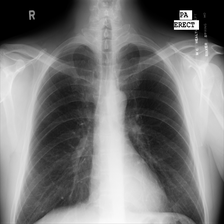

In [76]:
Image.fromarray(data_batch.data.cpu().numpy().astype(np.uint8)[1].transpose(1, 2, 0))

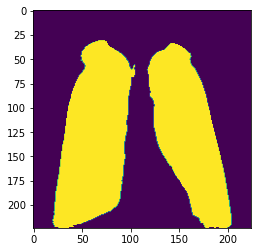

In [77]:
plt.imshow(out_cut[1].transpose(1, 2, 0))

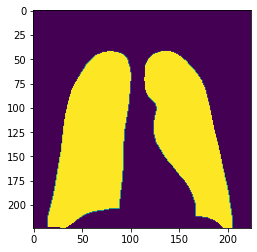

In [78]:
plt.imshow(_[1].numpy())

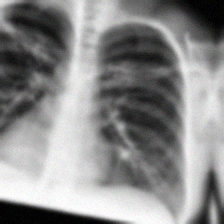

In [80]:
Image.fromarray(data_batch.data.cpu().numpy().astype(np.uint8)[1].transpose(1, 2, 0))

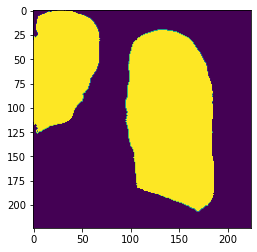

In [81]:
plt.imshow(out_cut[1].transpose(1, 2, 0))

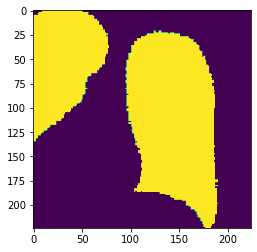

In [82]:
plt.imshow(_[1].numpy())